In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
from pathlib import Path

sys.path.append('/mnt/nas05/data01/francesco/progetto_simone/ionosphere/')
from src.data.dataset import get_ionosphere_transform, reverse_ionosphere_transform, IONOSPHERE_PREPROCESS

plt.style.use('default')
%matplotlib inline

/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [2]:
# Load a sample file
data_path = '/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/pickled_maps/'
files = sorted(list(Path(data_path).glob('*.npy')))

# Load a random file
sample_file = files[np.random.randint(0, len(files))]
print(f"Loading: {sample_file.name}")

data = np.load(sample_file, allow_pickle=True)
original_data = torch.from_numpy(data[0]).float().unsqueeze(0)

print(f"Original data shape: {original_data.shape}")
print(f"Original data range: [{original_data.min():.2f}, {original_data.max():.2f}]")
print(f"Original data mean: {original_data.mean():.2f}")
print(f"Original data std: {original_data.std():.2f}")

Loading: map_2024_2_14_6_36_0.npy
Original data shape: torch.Size([1, 24, 360])
Original data range: [-26743.20, 22887.10]
Original data mean: 546.30
Original data std: 10432.43


In [3]:
# Test all scaling methods
scaling_methods = [
    {"name": "No Scaling", "config": {"min": -80000, "max": 80000, "scaling": None}},
    {"name": "Log10", "config": {"min": -80000, "max": 80000, "scaling": "log10"}},
    {"name": "Sqrt", "config": {"min": -80000, "max": 80000, "scaling": "sqrt"}},
    {"name": "Symlog (scale=10000)", "config": {"min": -80000, "max": 80000, "scaling": "symlog", "scale_factor": 10000}},
    {"name": "Symlog (scale=5000)", "config": {"min": -80000, "max": 80000, "scaling": "symlog", "scale_factor": 5000}},
]

results = []

for method in scaling_methods:
    config = method["config"]
    
    # Apply transformation
    normalized = get_ionosphere_transform(original_data, config=config)
    
    # Reverse transformation
    reverted = reverse_ionosphere_transform(normalized, config=config)
    
    # Calculate reconstruction error
    error = torch.abs(original_data - reverted).mean().item()
    
    results.append({
        "name": method["name"],
        "config": config,
        "normalized": normalized,
        "reverted": reverted,
        "error": error
    })
    
    print(f"{method['name']:25s} | Normalized range: [{normalized.min():.4f}, {normalized.max():.4f}] | Reconstruction error: {error:.4f}")

No Scaling                | Normalized range: [-0.3343, 0.2861] | Reconstruction error: 0.0025
Log10                     | Normalized range: [-0.9029, 0.8892] | Reconstruction error: 0.0038
Sqrt                      | Normalized range: [-0.5782, 0.5349] | Reconstruction error: 0.0013
Symlog (scale=10000)      | Normalized range: [-0.5923, 0.5418] | Reconstruction error: 0.0012
Symlog (scale=5000)       | Normalized range: [-0.6523, 0.6066] | Reconstruction error: 0.0013


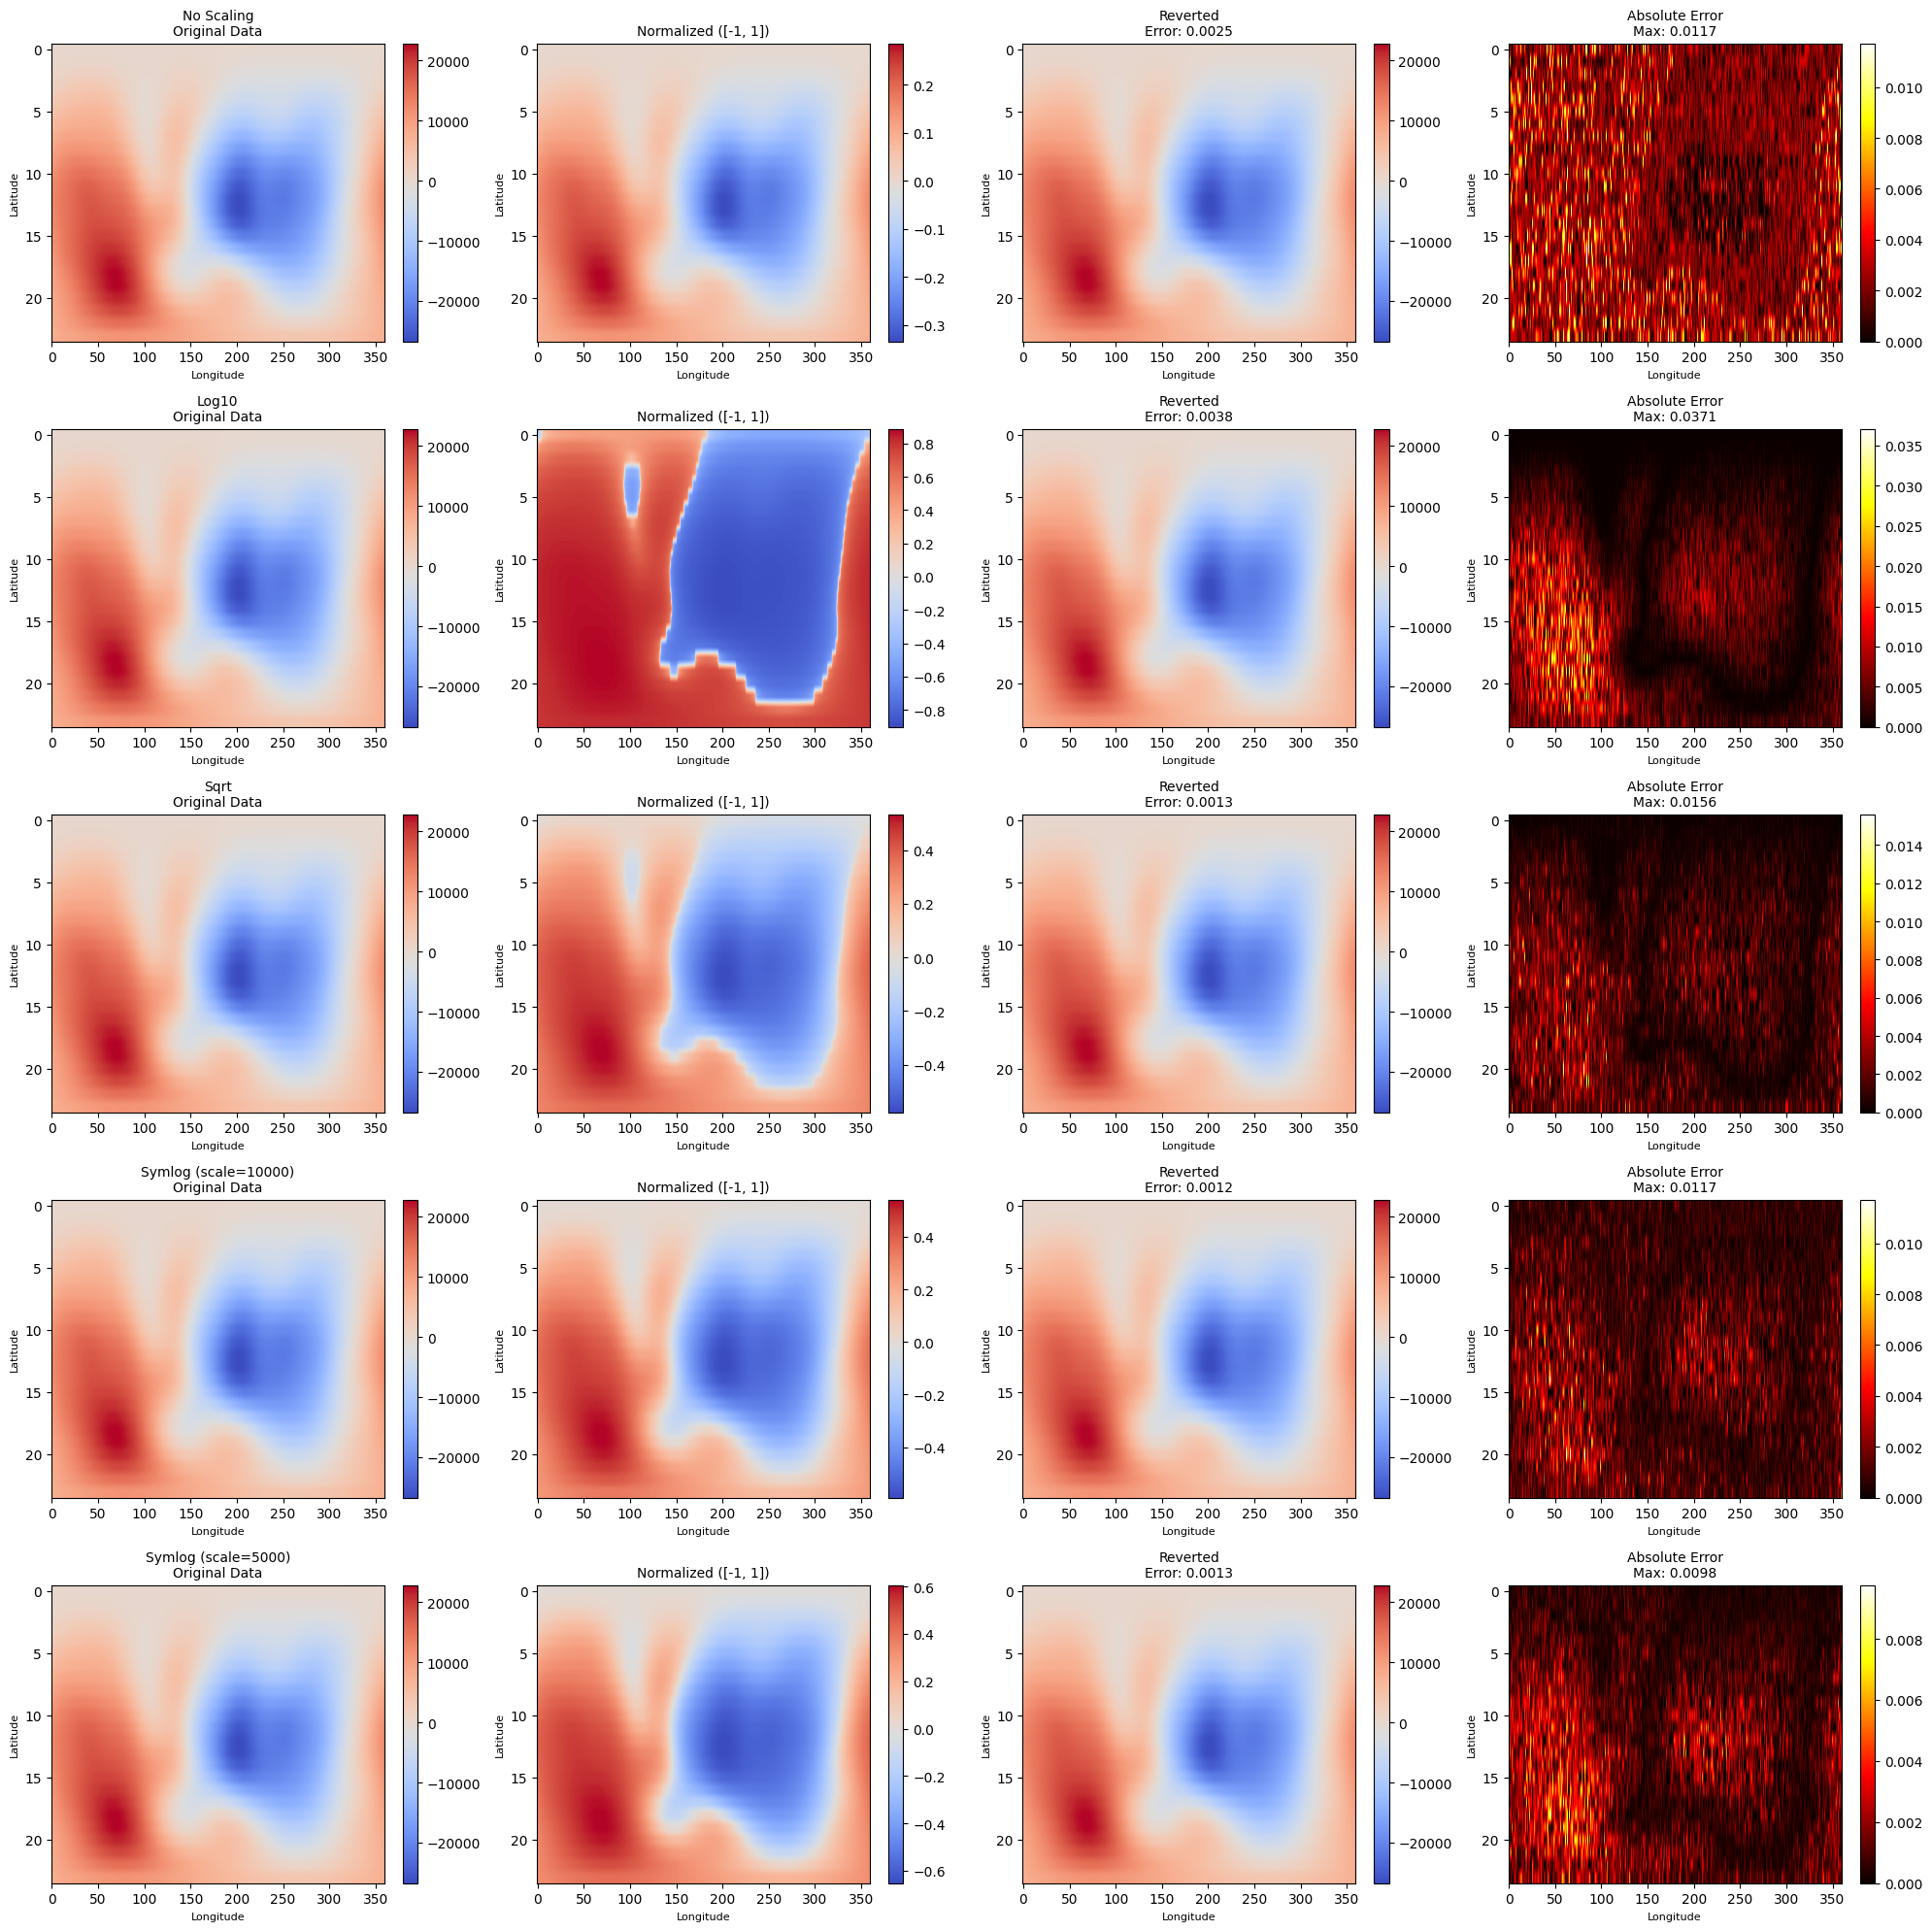

In [4]:
# Visualize all scaling methods
num_methods = len(results)
fig, axes = plt.subplots(num_methods, 4, figsize=(20, 4*num_methods))

if num_methods == 1:
    axes = axes.reshape(1, -1)

for i, result in enumerate(results):
    # Original
    im0 = axes[i, 0].imshow(original_data.squeeze().numpy(), cmap='coolwarm', aspect='auto')
    axes[i, 0].set_title(f'{result["name"]}\nOriginal Data', fontsize=10)
    axes[i, 0].set_ylabel('Latitude', fontsize=8)
    axes[i, 0].set_xlabel('Longitude', fontsize=8)
    plt.colorbar(im0, ax=axes[i, 0], fraction=0.046)
    
    # Normalized
    im1 = axes[i, 1].imshow(result['normalized'].squeeze().numpy(), cmap='coolwarm', aspect='auto')
    axes[i, 1].set_title(f'Normalized ([-1, 1])', fontsize=10)
    axes[i, 1].set_ylabel('Latitude', fontsize=8)
    axes[i, 1].set_xlabel('Longitude', fontsize=8)
    plt.colorbar(im1, ax=axes[i, 1], fraction=0.046)
    
    # Reverted
    im2 = axes[i, 2].imshow(result['reverted'].squeeze().numpy(), cmap='coolwarm', aspect='auto')
    axes[i, 2].set_title(f'Reverted\nError: {result["error"]:.4f}', fontsize=10)
    axes[i, 2].set_ylabel('Latitude', fontsize=8)
    axes[i, 2].set_xlabel('Longitude', fontsize=8)
    plt.colorbar(im2, ax=axes[i, 2], fraction=0.046)
    
    # Difference
    diff = torch.abs(original_data - result['reverted']).squeeze().numpy()
    im3 = axes[i, 3].imshow(diff, cmap='hot', aspect='auto')
    axes[i, 3].set_title(f'Absolute Error\nMax: {diff.max():.4f}', fontsize=10)
    axes[i, 3].set_ylabel('Latitude', fontsize=8)
    axes[i, 3].set_xlabel('Longitude', fontsize=8)
    plt.colorbar(im3, ax=axes[i, 3], fraction=0.046)

plt.tight_layout()
plt.show()

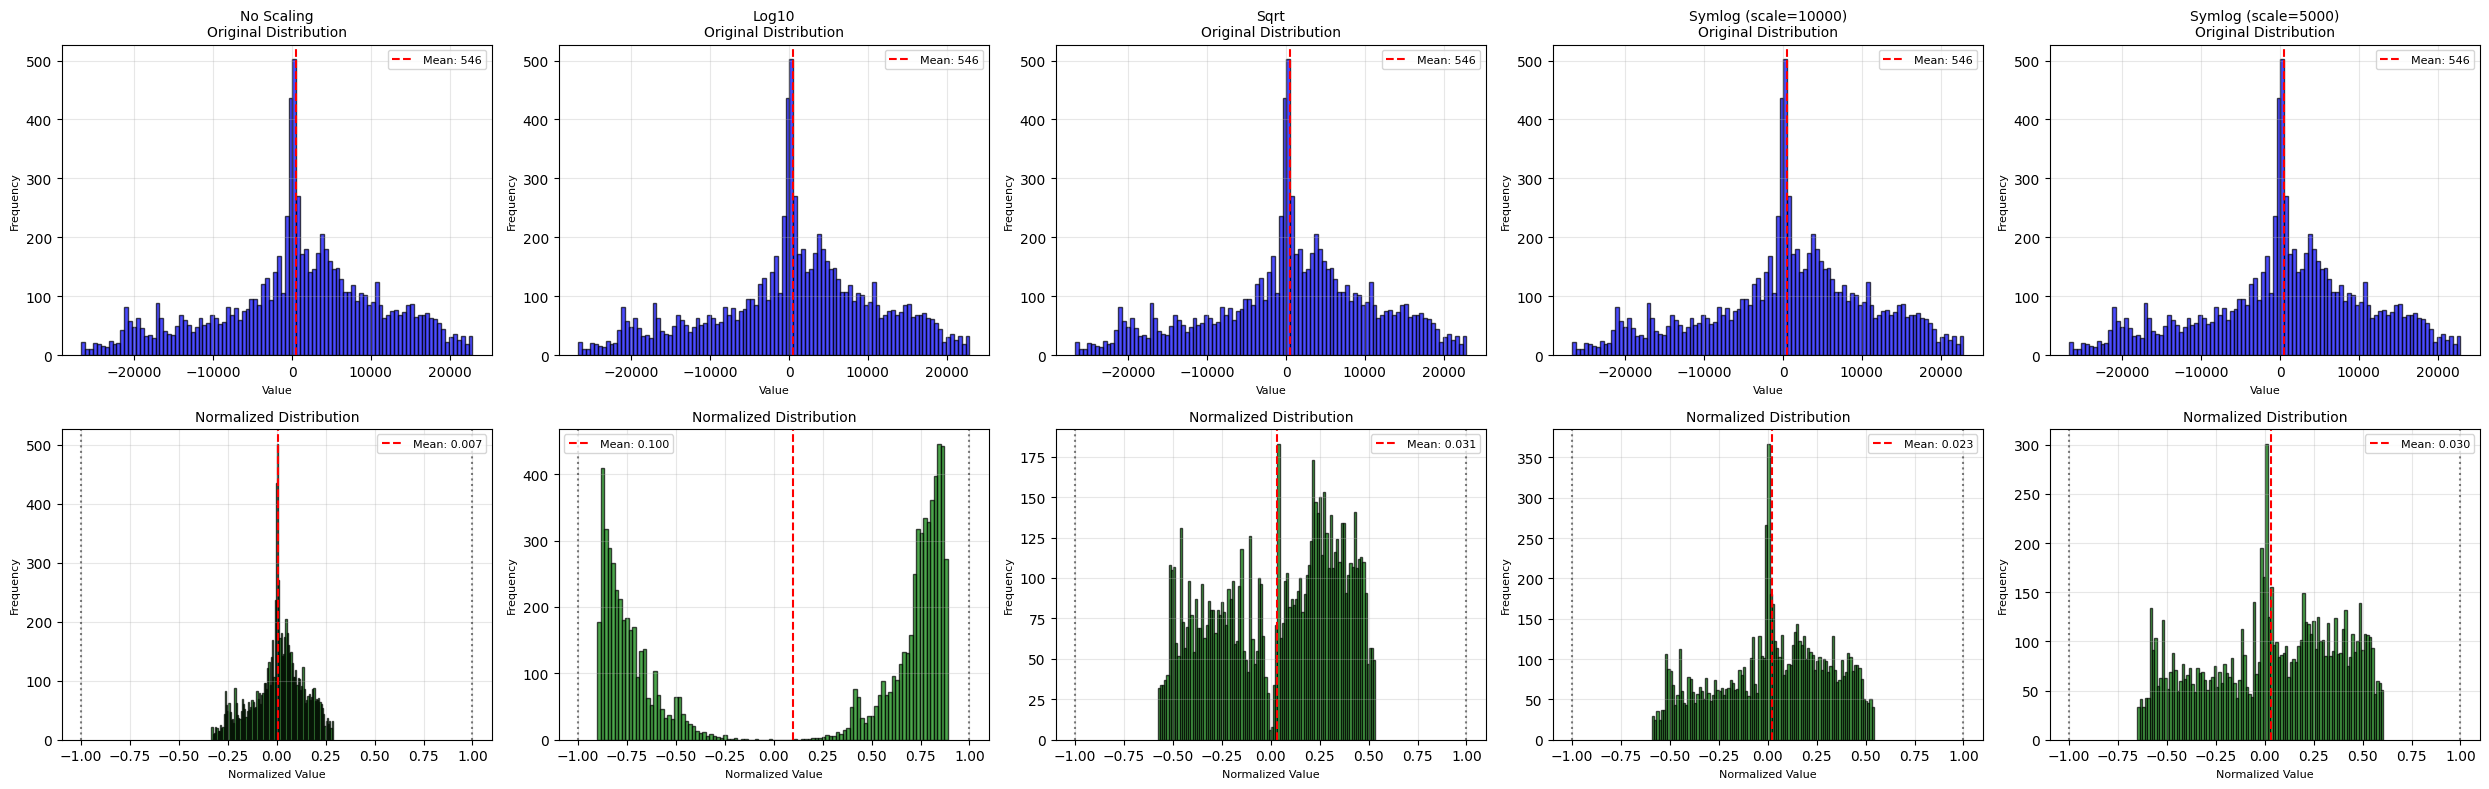

In [5]:
# Plot histograms: Original vs Normalized distributions
fig, axes = plt.subplots(2, num_methods, figsize=(5*num_methods, 8))

if num_methods == 1:
    axes = axes.reshape(-1, 1)

# Row 1: Original data distribution (same for all)
for i, result in enumerate(results):
    axes[0, i].hist(original_data.flatten().numpy(), bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[0, i].set_title(f'{result["name"]}\nOriginal Distribution', fontsize=10)
    axes[0, i].set_xlabel('Value', fontsize=8)
    axes[0, i].set_ylabel('Frequency', fontsize=8)
    axes[0, i].axvline(original_data.mean().item(), color='red', linestyle='--', label=f'Mean: {original_data.mean():.0f}')
    axes[0, i].legend(fontsize=8)
    axes[0, i].grid(True, alpha=0.3)

# Row 2: Normalized data distribution
for i, result in enumerate(results):
    normalized_flat = result['normalized'].flatten().numpy()
    axes[1, i].hist(normalized_flat, bins=100, alpha=0.7, color='green', edgecolor='black')
    axes[1, i].set_title(f'Normalized Distribution', fontsize=10)
    axes[1, i].set_xlabel('Normalized Value', fontsize=8)
    axes[1, i].set_ylabel('Frequency', fontsize=8)
    axes[1, i].axvline(normalized_flat.mean(), color='red', linestyle='--', label=f'Mean: {normalized_flat.mean():.3f}')
    axes[1, i].axvline(-1, color='black', linestyle=':', alpha=0.5)
    axes[1, i].axvline(1, color='black', linestyle=':', alpha=0.5)
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].set_xlim(-1.1, 1.1)

plt.tight_layout()
plt.show()

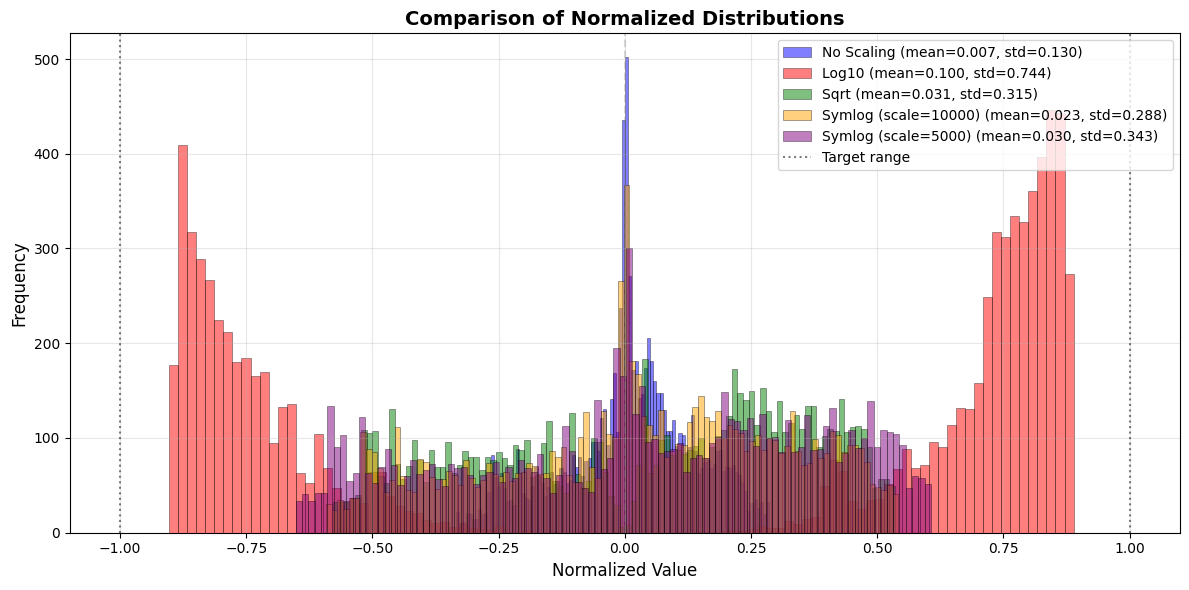

In [6]:
# Overlay all normalized distributions for comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, result in enumerate(results):
    normalized_flat = result['normalized'].flatten().numpy()
    ax.hist(normalized_flat, bins=100, alpha=0.5, color=colors[i], 
            label=f'{result["name"]} (mean={normalized_flat.mean():.3f}, std={normalized_flat.std():.3f})', 
            edgecolor='black', linewidth=0.5)

ax.set_title('Comparison of Normalized Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Normalized Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.axvline(-1, color='black', linestyle=':', alpha=0.5, label='Target range')
ax.axvline(1, color='black', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.1, 1.1)

plt.tight_layout()
plt.show()

In [7]:
# Print detailed statistics
print("="*100)
print("SCALING METHODS COMPARISON")
print("="*100)
print(f"{'Method':<25s} | {'Norm Min':>10s} | {'Norm Max':>10s} | {'Norm Mean':>10s} | {'Norm Std':>10s} | {'Recon Error':>12s}")
print("-"*100)

for result in results:
    norm_data = result['normalized'].flatten().numpy()
    print(f"{result['name']:<25s} | {norm_data.min():>10.4f} | {norm_data.max():>10.4f} | "
          f"{norm_data.mean():>10.4f} | {norm_data.std():>10.4f} | {result['error']:>12.4f}")

print("="*100)

SCALING METHODS COMPARISON
Method                    |   Norm Min |   Norm Max |  Norm Mean |   Norm Std |  Recon Error
----------------------------------------------------------------------------------------------------
No Scaling                |    -0.3343 |     0.2861 |     0.0068 |     0.1304 |       0.0025
Log10                     |    -0.9029 |     0.8892 |     0.1002 |     0.7435 |       0.0038
Sqrt                      |    -0.5782 |     0.5349 |     0.0309 |     0.3148 |       0.0013
Symlog (scale=10000)      |    -0.5923 |     0.5418 |     0.0225 |     0.2882 |       0.0012
Symlog (scale=5000)       |    -0.6523 |     0.6066 |     0.0301 |     0.3425 |       0.0013


Testing on 10 random samples...



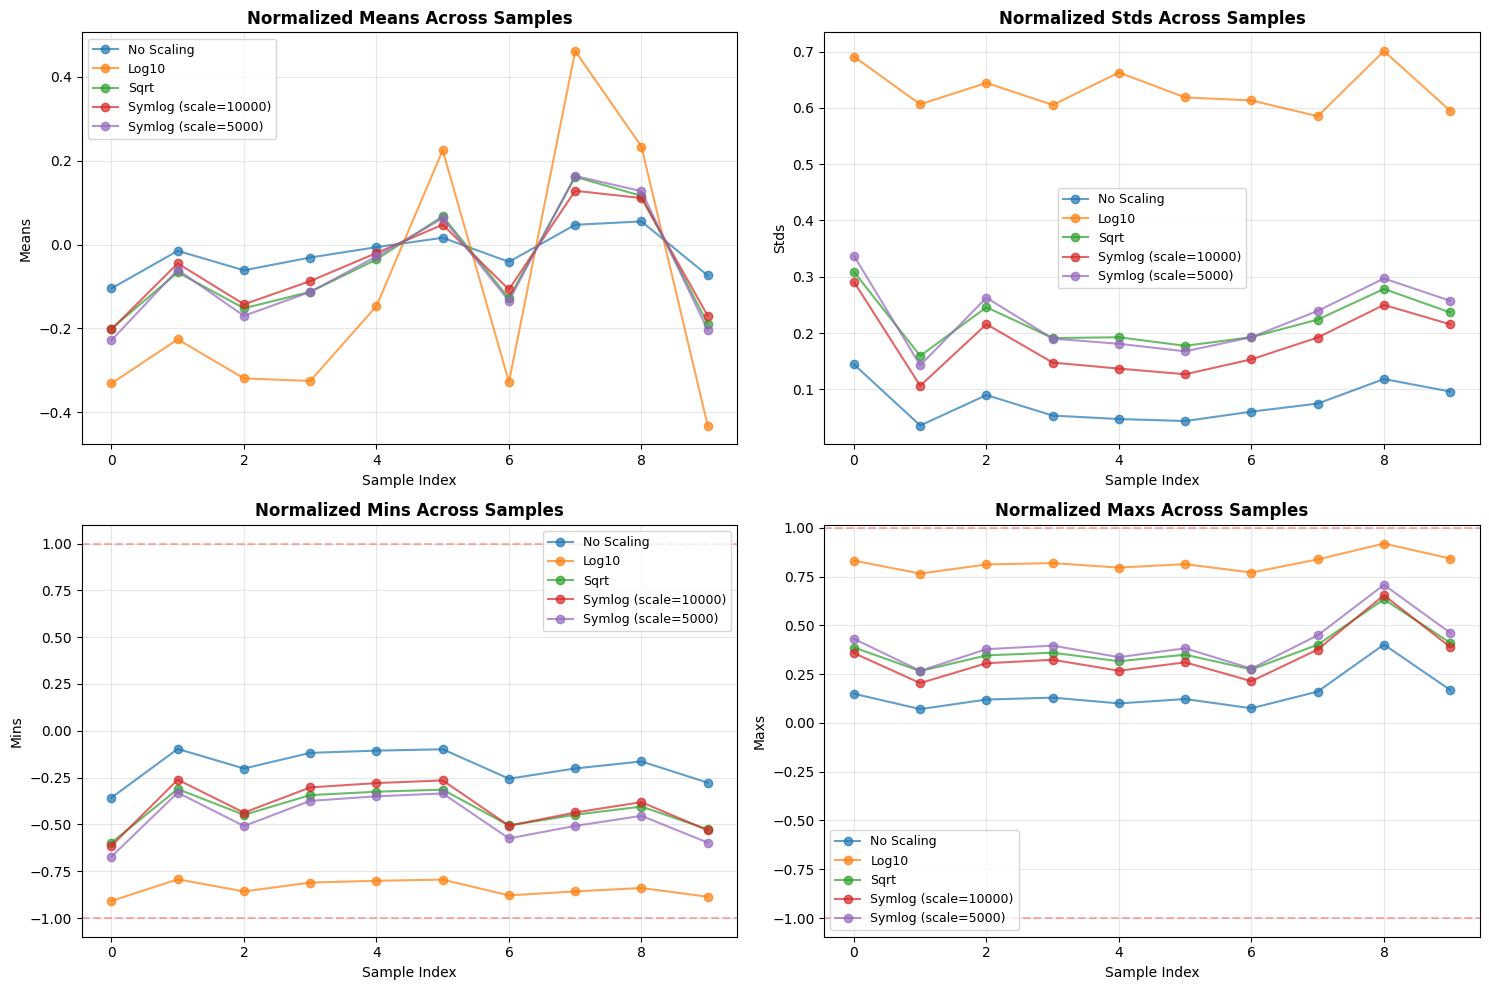


STATISTICS ACROSS MULTIPLE SAMPLES
Method                    |   Avg Mean |    Avg Std |       Min Range |       Max Range
----------------------------------------------------------------------------------------------------
No Scaling                |    -0.0215 |     0.0763 | [-0.357, -0.097] |  [0.071, 0.402]
Log10                     |    -0.1188 |     0.6324 | [-0.909, -0.793] |  [0.765, 0.919]
Sqrt                      |    -0.0539 |     0.2206 | [-0.598, -0.311] |  [0.266, 0.634]
Symlog (scale=10000)      |    -0.0487 |     0.1835 | [-0.615, -0.261] |  [0.204, 0.654]
Symlog (scale=5000)       |    -0.0584 |     0.2267 | [-0.672, -0.330] |  [0.267, 0.708]


In [8]:
# Test on multiple samples to see distribution consistency
num_samples = 10
sample_indices = np.random.choice(len(files), num_samples, replace=False)

stats_per_method = {result['name']: {'means': [], 'stds': [], 'mins': [], 'maxs': []} 
                    for result in results}

print(f"Testing on {num_samples} random samples...\n")

for idx in sample_indices:
    data = np.load(files[idx], allow_pickle=True)
    sample_data = torch.from_numpy(data[0]).float().unsqueeze(0)
    
    for result in results:
        normalized = get_ionosphere_transform(sample_data, config=result['config'])
        norm_flat = normalized.flatten().numpy()
        
        stats_per_method[result['name']]['means'].append(norm_flat.mean())
        stats_per_method[result['name']]['stds'].append(norm_flat.std())
        stats_per_method[result['name']]['mins'].append(norm_flat.min())
        stats_per_method[result['name']]['maxs'].append(norm_flat.max())

# Plot statistics across samples
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (stat_name, ax) in enumerate(zip(['means', 'stds', 'mins', 'maxs'], axes.flatten())):
    for method_name, stats in stats_per_method.items():
        ax.plot(stats[stat_name], 'o-', label=method_name, alpha=0.7)
    
    ax.set_title(f'Normalized {stat_name.capitalize()} Across Samples', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel(stat_name.capitalize(), fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if stat_name in ['mins', 'maxs']:
        ax.axhline(-1, color='red', linestyle='--', alpha=0.3, label='Target range')
        ax.axhline(1, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*100)
print("STATISTICS ACROSS MULTIPLE SAMPLES")
print("="*100)
print(f"{'Method':<25s} | {'Avg Mean':>10s} | {'Avg Std':>10s} | {'Min Range':>15s} | {'Max Range':>15s}")
print("-"*100)

for method_name, stats in stats_per_method.items():
    avg_mean = np.mean(stats['means'])
    avg_std = np.mean(stats['stds'])
    min_range = f"[{np.min(stats['mins']):.3f}, {np.max(stats['mins']):.3f}]"
    max_range = f"[{np.min(stats['maxs']):.3f}, {np.max(stats['maxs']):.3f}]"
    
    print(f"{method_name:<25s} | {avg_mean:>10.4f} | {avg_std:>10.4f} | {min_range:>15s} | {max_range:>15s}")

print("="*100)